In [1]:

import random

from numpy.ma.core import indices
from sentry_sdk.utils import epoch

%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import ast
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.utils as vutils
import torch.optim as optim
from torchvision import datasets, transforms
from PIL import Image
import logging
logging.propagate = False
logging.getLogger().setLevel(logging.ERROR)

# Set random seed for reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
import matplotlib.pyplot as plt


In [2]:

from gan.utils import Utils
from gan.model_config import ngpu, gene_expression_validation, noise_scale, nz
from gan.dcgan import Generator, losses_g, losses_d


def validate_DCGAN(checkpoint_path):
    netG = Generator(ngpu)
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    netG.to(device)

    netG.load_state_dict(torch.load(checkpoint_path, map_location=device, weights_only=True))
    gene_expression = Utils.load_gene_expression(gene_expression_validation , noise_scale)
    for i, gene in enumerate(gene_expression):
        input_tensor = torch.tensor(gene, dtype=torch.float32).view(1, nz, 1, 1).to(device)
        output_image = netG(input_tensor)
        output_image = output_image.to('cpu').detach()
        output_image = (output_image + 1) / 2.0
        output_image_np = output_image.squeeze(0).permute(1, 2, 0).numpy()
        plt.imsave(f'result/validation/{i}.jpg', output_image_np)

In [2]:
from gan.model_config import random_indices


def predict_image(model_path, gene_expression):
    # load model
    netG = Generator(1)
    netG.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    netG.to(device)
    netG.eval()
    # get random genes expression and random images
    image_fixed = [f'data/image/spots_validation/validation/{i}.jpg' for i in random_indices]
    image_tensors = []
    for img_path in image_fixed:
        img = Image.open(img_path)
        img_tensor = ToTensor()(img)  # Convert to tensor
        image_tensors.append(img_tensor)

    # Convert the list of tensors to a single tensor
    real_images = torch.stack(image_tensors)

    gene_expression_fixed = np.array([gene_expression[i] for i in random_indices])
    tensor = torch.tensor(gene_expression_fixed, dtype=torch.float32)
    tensor = tensor.unsqueeze(2).unsqueeze(3)
    fixed_noise = tensor.to(device)
    fixed = fixed_noise
    
    noise = np.array(gene_expression)
    noise = torch.tensor(noise, dtype=torch.float32)
    noise = noise.unsqueeze(2).unsqueeze(3)
    noise = noise.to(device)

    random_noise = torch.randn(len(random_indices), nz, 1, 1, device=device)
    # Min and max values in the noise tensor
    min_noise, max_noise = random_noise.min(), random_noise.max()
    scaled_noise = 2 * (random_noise - min_noise) / (max_noise - min_noise) - 1
    scaled_noise = scaled_noise.to(device)
    fixed_noise = fixed_noise + noise_scale * scaled_noise

    random_noise = torch.randn(len(gene_expression), nz, 1, 1, device=device)
    # Min and max values in the noise tensor
    min_noise, max_noise = random_noise.min(), random_noise.max()
    scaled_noise = 2 * (random_noise - min_noise) / (max_noise - min_noise) - 1
    scaled_noise = scaled_noise.to(device)
    noise = noise + noise_scale * scaled_noise
    indices = torch.randperm(noise.size(0))
    shuffled_noise = noise[indices]
    noise = shuffled_noise

    
    full_image = [f'data/image/spots_validation/validation/{i}.jpg' for i in range(500)]

    full_image_tensors = []
    for img_path in full_image:
        img = Image.open(img_path)
        img_tensor = ToTensor()(img)  # Convert to tensor
        full_image_tensors.append(img_tensor)

    shuffled_image = full_image_tensors[indices]
    full_image_tensors = shuffled_image
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        fake_full = netG(noise).detach().cpu()

    for i, fake_img in enumerate(fake_full):
        fake_img = (fake_img + 1) / 2.0  # Rescale to [0, 1]
        fake_img_np = fake_img.permute(1, 2, 0).numpy()
    
        real_image = full_image_tensors[i]
        real_image_np = real_image.permute(1, 2, 0).numpy()
    
        # Concatenate real and fake images along the width
        concatenated_image = np.concatenate((real_image_np, fake_img_np), axis=1)
    
        plt.imsave(f'result/validation/fake_image_{i}.jpg', concatenated_image)
        

    stacked_images = torch.stack((real_images, fake), dim=1)

    # Reshape the tensor to mix the images
    mixed_images = stacked_images.view(-1, *real_images.shape[1:])

    # Generate grid of images
    grid = vutils.make_grid(mixed_images, padding=2, normalize=True, scale_each=True)

    grid_np = grid.cpu().numpy()

    # Transpose the dimensions to (H, W, C) for plotting
    grid_np = grid_np.transpose((1, 2, 0))

    # Plot the grid
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_np)
    plt.axis('off')  # Hide axes
    plt.show()

    # fake_images = fake
    # mse_image_list = []
    # mse_gene_list = []
    # euclidean_distance = []
    # pearson = []
    # for i in range(num_predict_image):
    #     real_img = real_images[i]
    #     fake_img = fake_images[i]
    #     try:
    #         mse = torch.nn.functional.mse_loss(fake_img, real_img).item()
    #         mse_gene = torch.nn.functional.mse_loss(fixed[i], fixed_noise[i]).item()
    #         print(mse_gene, mse)
    #         mse_image_list.append(mse)
    #         pearson.append(pearsonr(fixed[i].cpu().numpy().reshape(-1).tolist(), fixed_noise[i].cpu().numpy().reshape(-1).tolist())[0])
    #         euclidean_distance.append(np.linalg.norm(fixed[i].cpu().numpy() - fixed_noise[i].cpu().numpy()))
    #         mse_gene_list.append(mse_gene)
    #     except Exception as e:
    #         print(e)
    # return mse_image_list, mse_gene_list, euclidean_distance, pearson
# gene_expression = Utils.load_gene_expression(gene_expression_validation , noise_scale)
# predict_image('/home/anlt69/Downloads/DCgan_3Nov2024/model/model_epoch_800.h5', gene_expression)

In [4]:
from gan.wgan_div import predict_validate_wgan
predict_validate_wgan('/home/anlt69/Downloads/Wgan_5Nov2024/model/model_epoch_400.h5')

TypeError: __init__() takes 1 positional argument but 2 were given

In [15]:
from gan.model_config import random_indices

def predict_image(model_path, gene_expression):
    # load model
    netG = Generator(1)
    netG.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    netG.to(device)
    netG.eval()
    
    noise = np.array(gene_expression)
    noise = torch.tensor(noise, dtype=torch.float32)
    noise = noise.unsqueeze(2).unsqueeze(3)
    noise = noise.to(device)


    random_noise = torch.randn(len(gene_expression), nz, 1, 1, device=device)
    min_noise, max_noise = random_noise.min(), random_noise.max()
    scaled_noise = 2 * (random_noise - min_noise) / (max_noise - min_noise) - 1
    scaled_noise = scaled_noise.to(device)
    noise = noise + noise_scale * scaled_noise

    full_image = [f'data/image/spots_validation/validation/{i}.jpg' for i in range(500)]

    full_image_tensors = []
    for img_path in full_image:
        img = Image.open(img_path)
        img_tensor = ToTensor()(img)  # Convert to tensor
        full_image_tensors.append(img_tensor)

    with torch.no_grad():
        fake_full = netG(noise).detach().cpu()

    for i, fake_img in enumerate(fake_full):
        fake_img = (fake_img + 1) / 2.0  # Rescale to [0, 1]
        fake_img_np = fake_img.permute(1, 2, 0).numpy()

        # real_image = full_image_tensors[i]
        # real_image_np = real_image.permute(1, 2, 0).numpy()
        # 
        # # Concatenate real and fake images along the width
        # concatenated_image = np.concatenate((real_image_np, fake_img_np), axis=1)

        plt.imsave(f'result/validation/fake_image_{i}.jpg', fake_img_np)

gene_expression = Utils.load_gene_expression(gene_expression_validation , noise_scale)
predict_image('/home/anlt69/Downloads/DCgan_6Nov2024/model/model_epoch_1000.h5', gene_expression)

/tmp/ipykernel_10690/424160315.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  netG.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


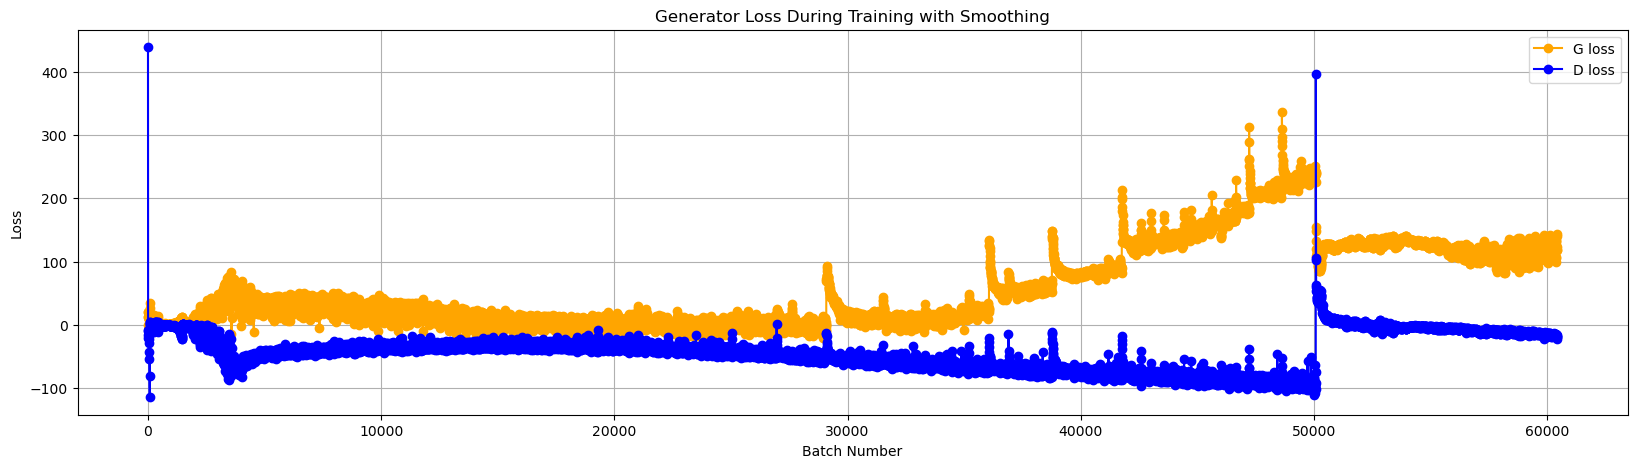

In [1]:
import re
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Read log data from the file
with open('/home/anlt69/Downloads/training.log', 'r') as file:
    log_data = file.readlines()

d_losses = []
g_losses = []
batch_numbers = []
batch_number = -1
for line in log_data[6436:]:
    batch_match = re.search(r'\[Epoch (\d+)/\d+\] \[Batch (\d+)/\d+\]', line)
    if batch_match:
        batch_number = int(batch_match.group(2))
        epoch = int(batch_match.group(1))
        match = re.search(r'\[D loss: ([\-\d\.]+)\] \[G loss: ([\-\d\.]+)\]', line)
        if match:
            d_loss = float(match.group(1))
            g_loss = float(match.group(2))
            d_losses.append(d_loss)
            g_losses.append(g_loss)
            batch_numbers.append(epoch*99+batch_number)

plt.figure(figsize=(20, 5))
plt.plot(batch_numbers, g_losses, label='G loss', color='orange', marker='o', alpha=1)
plt.plot(batch_numbers, d_losses, label='D loss', color='blue', marker='o', alpha=1)
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.title('Generator Loss During Training with Smoothing')
plt.legend()
plt.grid()
plt.show()


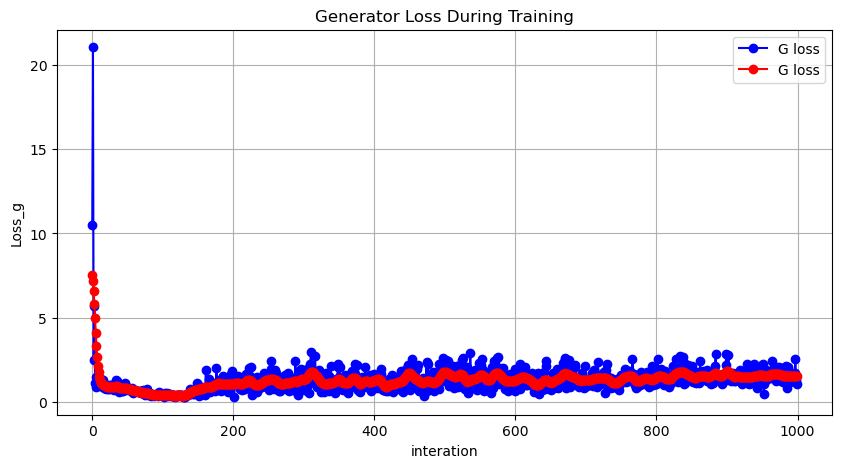

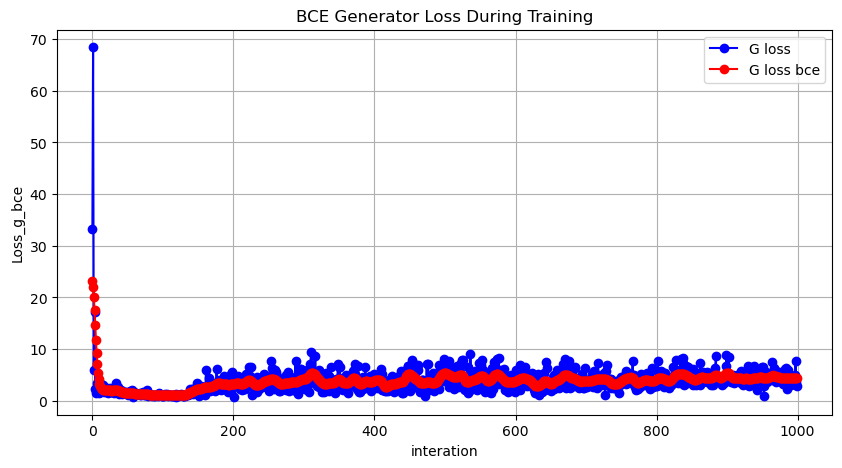

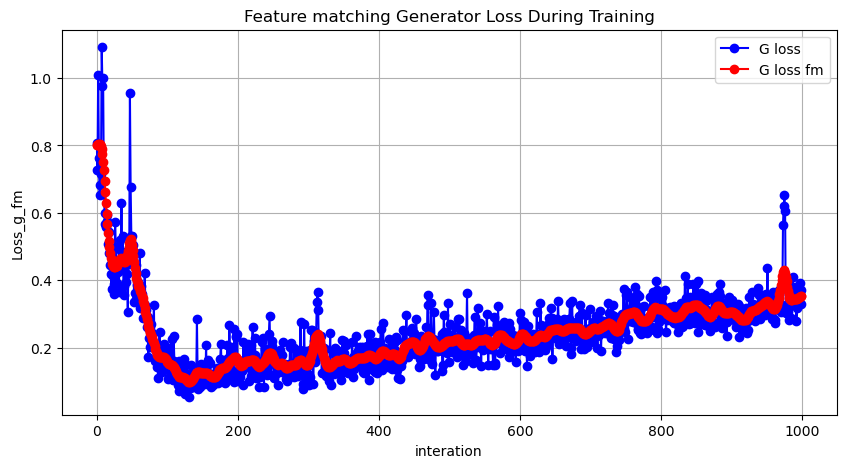

In [34]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d

df = pd.read_csv("/home/anlt69/Downloads/DCgan_6Nov2024/model/losses.csv")

losses_g = df['loss_g'].tolist()

losses_g_bce = df['loss_g_bce'].tolist()

losses_g_fm = df['loss_g_fm'].tolist()

losses_d = df['loss_d'].tolist()

losses_d_real = df['d_real'].tolist()

losses_d_fake = df['d_fake1'].tolist()

indices = df['Unnamed: 0'].tolist()


smoothed_losses_g = gaussian_filter1d(losses_g, sigma=4)
plt.figure(figsize=(10, 5))
plt.plot(indices, losses_g, label='G loss', color='blue', marker='o', alpha=1)
plt.plot(indices, smoothed_losses_g , label='G loss', color='red', marker='o', alpha=1)
plt.xlabel('interation')
plt.ylabel('Loss_g')
plt.title('Generator Loss During Training')
plt.legend()
plt.grid()
plt.show()


smoothed_losses_g = gaussian_filter1d(losses_g_bce, sigma=4)
plt.figure(figsize=(10, 5))
plt.plot(indices, losses_g_bce, label='G loss', color='blue', marker='o', alpha=1)
plt.plot(indices, smoothed_losses_g , label='G loss bce', color='red', marker='o', alpha=1)
plt.xlabel('interation')
plt.ylabel('Loss_g_bce')
plt.title('BCE Generator Loss During Training')
plt.legend()
plt.grid()
plt.show()

smoothed_losses_g = gaussian_filter1d(losses_g_fm, sigma=4)
plt.figure(figsize=(10, 5))
plt.plot(indices, losses_g_fm, label='G loss', color='blue', marker='o', alpha=1)
plt.plot(indices, smoothed_losses_g , label='G loss fm', color='red', marker='o', alpha=1)
plt.xlabel('interation')
plt.ylabel('Loss_g_fm')
plt.title('Feature matching Generator Loss During Training')
plt.legend()
plt.grid()
plt.show()


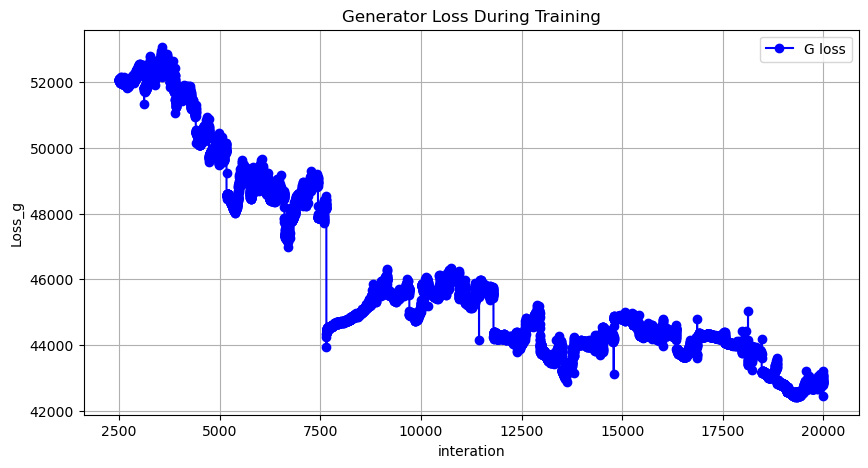

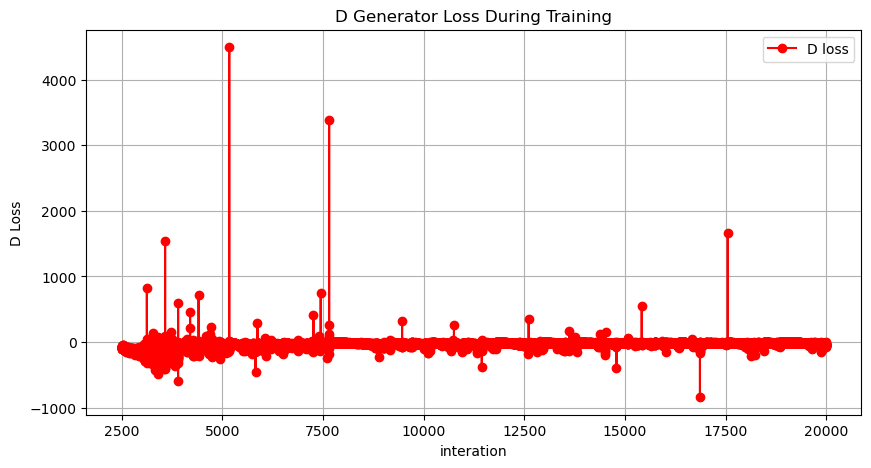

In [6]:
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt

df = pd.read_csv("/home/anlt69/Downloads/Wgan_13Nov2024/Wgan_13Nov2024_1/model/losses.csv")

losses_g = df['loss_g'].tolist()

losses_d = df['loss_d'].tolist()

indices = df['Unnamed: 0'].tolist()

# smoothed_losses_g = gaussian_filter1d(losses_g, sigma=4)
plt.figure(figsize=(10, 5))
plt.plot(indices[2500:], losses_g[2500:], label='G loss', color='blue', marker='o', alpha=1)
plt.xlabel('interation')
plt.ylabel('Loss_g')
plt.title('Generator Loss During Training')
plt.legend()
plt.grid()
plt.show()


# smoothed_losses_g = gaussian_filter1d(losses_g_bce, sigma=4)
plt.figure(figsize=(10, 5))
plt.plot(indices[2500:], losses_d[2500:] , label='D loss', color='red', marker='o', alpha=1)
plt.xlabel('interation')
plt.ylabel('D Loss')
plt.title('D Generator Loss During Training')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df = pd.read_csv('/home/anlt69/Downloads/WganDiv_13Nov2024/model/losses.csv')